# Part 3: Compression

In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)
import os
os.environ['PATH'] = '/opt/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']

2021-11-24 00:59:58.489738: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2021-11-24 00:59:58.489799: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Fetch the jet tagging dataset from Open ML

In [2]:
X_train_val = np.load('X_train_val.npy')
X_test = np.load('X_test.npy')
y_train_val = np.load('y_train_val.npy')
y_test = np.load('y_test.npy')
classes = np.load('classes.npy', allow_pickle=True)

## Now construct a model
We'll use the same architecture as in part 1: 3 hidden layers with 64, then 32, then 32 neurons. Each layer will use `relu` activation.
Add an output layer with 5 neurons (one for each class), then finish with Softmax activation.

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks

In [4]:
model = Sequential()
model.add(Dense(64, input_shape=(16,), name='fc1', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu1'))
model.add(Dense(32, name='fc2', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu2'))
model.add(Dense(32, name='fc3', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu3'))
model.add(Dense(5, name='output', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='softmax', name='softmax'))

2021-11-24 01:00:13.371398: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-24 01:00:13.371464: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-24 01:00:13.371501: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-fiwo735): /proc/driver/nvidia/version does not exist
2021-11-24 01:00:13.371849: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-24 01:00:13.380504: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 229999

## Train sparse
This time we'll use the Tensorflow model optimization sparsity to train a sparse model (forcing many weights to '0'). In this instance, the target sparsity is 75%

In [5]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning
pruning_params = {"pruning_schedule" : pruning_schedule.ConstantSparsity(0.75, begin_step=2000, frequency=100)}
model = prune.prune_low_magnitude(model, **pruning_params)

Instructions for updating:
Please use `layer.add_weight` method instead.


## Train the model
We'll use the same settings as the model for part 1: Adam optimizer with categorical crossentropy loss.
The callbacks will decay the learning rate and save the model into a directory 'model_2'
The model isn't very complex, so this should just take a few minutes even on the CPU.
If you've restarted the notebook kernel after training once, set `train = False` to load the trained model rather than training again.

In [6]:
train = True
if train:
    adam = Adam(lr=0.0001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(stop_patience = 1000,
                              lr_factor = 0.5,
                              lr_patience = 10,
                              lr_epsilon = 0.000001,
                              lr_cooldown = 2,
                              lr_minimum = 0.0000001,
                              outputDir = 'model_2')
    callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
    model.fit(X_train_val, y_train_val, batch_size=1024,
              epochs=30, validation_split=0.25, shuffle=True,
              callbacks = callbacks.callbacks)
    # Save the model again but with the pruning 'stripped' to use the regular layer types
    model = strip_pruning(model)
    model.save('model_2/KERAS_check_best_model.h5')
else:
    from tensorflow.keras.models import load_model
    model = load_model('model_2/KERAS_check_best_model.h5')

2021-11-24 01:00:48.935509: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.


Epoch 1/30
  1/487 [..............................] - ETA: 0s - loss: 1.6388 - accuracy: 0.3027WARNING:tensorflow:From /srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
 51/487 [==>...........................] - ETA: 1s - loss: 1.6041 - accuracy: 0.3154

2021-11-24 01:00:51.779085: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-11-24 01:00:51.793636: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: model_2/logs/train/plugins/profile/2021_11_24_01_00_51
2021-11-24 01:00:51.795142: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to model_2/logs/train/plugins/profile/2021_11_24_01_00_51/jupyter-fiwo735.trace.json.gz
2021-11-24 01:00:51.799786: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: model_2/logs/train/plugins/profile/2021_11_24_01_00_51
2021-11-24 01:00:51.799910: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for memory_profile.json.gz to model_2/logs/train/plugins/profile/2021_11_24_01_00_51/jupyter-fiwo735.memory_profile.json.gz
2021-11-24 01:00:51.800242: I tensorflow/python/profiler/internal/profiler_wrapper.cc:111] Creating directory: m

487/487 [==============================] - ETA: 0s - loss: 1.3290 - accuracy: 0.5161
***callbacks***
saving losses to model_2/losses.log

Epoch 00001: val_loss improved from inf to 1.12515, saving model to model_2/KERAS_check_best_model.h5

Epoch 00001: val_loss improved from inf to 1.12515, saving model to model_2/KERAS_check_best_model_weights.h5

Epoch 00001: saving model to model_2/KERAS_check_model_last.h5

Epoch 00001: saving model to model_2/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 2s 5ms/step - loss: 1.3290 - accuracy: 0.5161 - val_loss: 1.1252 - val_accuracy: 0.6363
Epoch 2/30
486/487 [============================>.] - ETA: 0s - loss: 1.0551 - accuracy: 0.6667
***callbacks***
saving losses to model_2/losses.log

Epoch 00002: val_loss improved from 1.12515 to 1.00706, saving model to model_2/KERAS_check_best_model.h5

Epoch 00002: val_loss improved from 1.12515 to 1.00706, saving model to model_2/KERAS_check_best_model_w

Epoch 14/30
484/487 [============================>.] - ETA: 0s - loss: 0.8150 - accuracy: 0.7282
***callbacks***
saving losses to model_2/losses.log

Epoch 00014: val_loss improved from 0.82221 to 0.81564, saving model to model_2/KERAS_check_best_model.h5

Epoch 00014: val_loss improved from 0.82221 to 0.81564, saving model to model_2/KERAS_check_best_model_weights.h5

Epoch 00014: saving model to model_2/KERAS_check_model_last.h5

Epoch 00014: saving model to model_2/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 2s 4ms/step - loss: 0.8149 - accuracy: 0.7282 - val_loss: 0.8156 - val_accuracy: 0.7286
Epoch 15/30
479/487 [============================>.] - ETA: 0s - loss: 0.8088 - accuracy: 0.7298
***callbacks***
saving losses to model_2/losses.log

Epoch 00015: val_loss improved from 0.81564 to 0.80984, saving model to model_2/KERAS_check_best_model.h5

Epoch 00015: val_loss improved from 0.81564 to 0.80984, saving model to model_2/KER

Epoch 27/30
486/487 [============================>.] - ETA: 0s - loss: 0.7630 - accuracy: 0.7428
***callbacks***
saving losses to model_2/losses.log

Epoch 00027: val_loss improved from 0.76895 to 0.76676, saving model to model_2/KERAS_check_best_model.h5

Epoch 00027: val_loss improved from 0.76895 to 0.76676, saving model to model_2/KERAS_check_best_model_weights.h5

Epoch 00027: saving model to model_2/KERAS_check_model_last.h5

Epoch 00027: saving model to model_2/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 2s 4ms/step - loss: 0.7631 - accuracy: 0.7428 - val_loss: 0.7668 - val_accuracy: 0.7424
Epoch 28/30
480/487 [============================>.] - ETA: 0s - loss: 0.7607 - accuracy: 0.7435
***callbacks***
saving losses to model_2/losses.log

Epoch 00028: val_loss improved from 0.76676 to 0.76460, saving model to model_2/KERAS_check_best_model.h5

Epoch 00028: val_loss improved from 0.76676 to 0.76460, saving model to model_2/KER

## Check sparsity
Make a quick check that the model was indeed trained sparse. We'll just make a histogram of the weights of the 1st layer, and hopefully observe a large peak in the bin containing '0'. Note logarithmic y axis.

% of zeros = 0.75


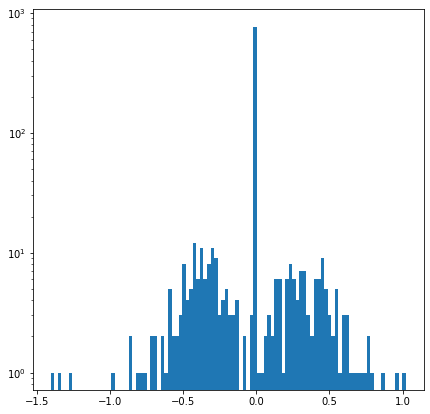

In [7]:
w = model.layers[0].weights[0].numpy()
h, b = np.histogram(w, bins=100)
plt.figure(figsize=(7,7))
plt.bar(b[:-1], h, width=b[1]-b[0])
plt.semilogy()
print('% of zeros = {}'.format(np.sum(w==0)/np.size(w)))

## Check performance
How does this 75% sparse model compare against the unpruned model? Let's report the accuracy and make a ROC curve. The pruned model is shown with solid lines, the unpruned model from part 1 is shown with dashed lines.
**Make sure you've trained the model from part 1**

Accuracy unpruned: 0.7502710843373493
Accuracy pruned:   0.7429879518072289


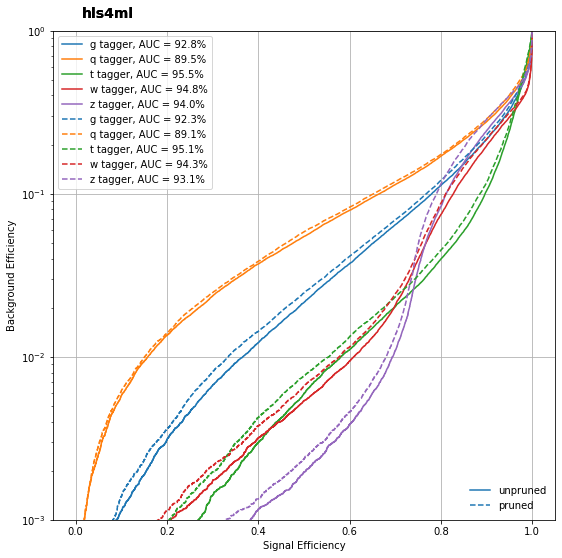

In [8]:
import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
model_ref = load_model('model_1/KERAS_check_best_model.h5')

y_ref = model_ref.predict(X_test)
y_prune = model.predict(X_test)

print("Accuracy unpruned: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))))
print("Accuracy pruned:   {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_prune, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_ref, classes)
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_prune, classes, linestyle='--')

from matplotlib.lines import Line2D
lines = [Line2D([0], [0], ls='-'),
         Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend
leg = Legend(ax, lines, labels=['unpruned', 'pruned'],
            loc='lower right', frameon=False)
ax.add_artist(leg)

# Convert the model to FPGA firmware with hls4ml
Let's use the default configuration: `ap_fixed<16,6>` precision everywhere and `ReuseFactor=1`, so we can compare with the part 1 model. We need to use `strip_pruning` to change the layer types back to their originals.

**The synthesis will take a while**

While the C-Synthesis is running, we can monitor the progress looking at the log file by opening a terminal from the notebook home, and executing:

`tail -f model_2/hls4ml_prj/vivado_hls.log`

In [9]:
import hls4ml

config = hls4ml.utils.config_from_keras_model(model, granularity='model')
print(config)
hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                       hls_config=config,
                                                       output_dir='model_2/hls4ml_prj',
                                                       part='xcu250-figd2104-2L-e')
hls_model.compile()
hls_model.build(csim=False)

/srv/conda/envs/notebook/lib/python3.7/site-packages/hls4ml/converters/__init__.py:16: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: Input
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: relu1, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: relu2, layer type: Activation
Layer name: fc3, layer type: Dense
  -> Activation (linear), layer name: fc3
Layer name: relu3, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: softmax, layer type: Activation
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}}
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: Dense, in

INFO: [HLS 200-111] Finished Standard Transforms Time (s): cpu = 00:00:34 ; elapsed = 00:00:36 . Memory (MB): peak = 1018.496 ; gain = 587.035 ; free physical = 3600 ; free virtual = 9694
INFO: [HLS 200-10] Checking synthesizability ...
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::mantissa' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:15) automatically.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::expv' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:18) automatically.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::__signbit' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:59

INFO: [HLS 200-489] Unrolling loop 'Accum2' (firmware/nnet_utils/nnet_dense_latency.h:113) in function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config11>' completely with a factor of 5.
INFO: [HLS 200-489] Unrolling loop 'Result' (firmware/nnet_utils/nnet_dense_latency.h:120) in function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config11>' completely with a factor of 5.
INFO: [HLS 200-489] Unrolling loop 'Loop-1' (firmware/nnet_utils/nnet_activation.h:76) in function 'nnet::relu<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, relu_config10>' completely with a factor of 32.
INFO: [HLS 200-489] Unrolling loop 'Product1' (firmware/nnet_utils/nnet_dense_latency.h:85) in function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 

INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::mantissa' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:15) automatically.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::expv' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:18) automatically.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::__signbit' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:59) automatically.
INFO: [XFORM 203-602] Inlining function 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' into 'generic_cast_IEEE754<int, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/Float

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>'(firmware/nnet_utils/nnet_dense_latency.h:45:23) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0' at call site (firmware/nnet_utils/nnet_dense.h:46->firmware/myproject.cpp:80) by setting 'weights.V' to 'w8.V'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0'(firmware/nnet_utils/nnet_dense_latency.h:45:23) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0' at call site (firmware/nnet_utils/nnet_dense.h:46->firmware/myproject.cpp:80) by setting 'biases[0].V' to 'b8.V.0'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latenc

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:45:23) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_dense.h:46->firmware/myproject.cpp:80) by setting 'biases[17].V' to 'b8.V.17'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:45:23) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nnet_ut

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>'(firmware/nnet_utils/nnet_dense_latency.h:45:23) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0' at call site (firmware/nnet_utils/nnet_dense.h:46->firmware/myproject.cpp:72) by setting 'weights.V' to 'w5.V'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0'(firmware/nnet_utils/nnet_dense_latency.h:45:23) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0.0' at call site (firmware/nnet_utils/nnet_dense.h:46->firmware/myproject.cpp:72) by setting 'biases[0].V' to 'b5.V.0'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latenc

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:45:23) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_dense.h:46->firmware/myproject.cpp:72) by setting 'biases[17].V' to 'b5.V.17'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:45:23) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nnet_ut

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0'(firmware/nnet_utils/nnet_dense_latency.h:45:23) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0' by setting 'biases[0].V' to 'b2.V.0'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0'(firmware/nnet_utils/nnet_dense_latency.h:45:23) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0' by setting 'biases[1].V' to 'b2.V.1'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0'(firmware/nnet_utils/nnet_dense

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:45:23) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[23].V' to 'b2.V.23'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:45:23) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[24].V' to 'b2.V.24'.
INFO: [XFORM 203-622

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:45:23) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[39].V' to 'b2.V.39'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:45:23) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:45:23) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[55].V' to 'b2.V.55'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:45:23) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode

INFO: [HLS 200-111] Finished Architecture Synthesis Time (s): cpu = 00:06:43 ; elapsed = 00:06:53 . Memory (MB): peak = 5298.527 ; gain = 4867.066 ; free physical = 1973 ; free virtual = 7318
INFO: [HLS 200-10] Starting hardware synthesis ...
INFO: [HLS 200-10] Synthesizing 'myproject' ...
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_2' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'dense_latency.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0..2'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 1.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 414.55 seconds; current allocated memory: 410.843 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: 

INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Starting global binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.36 seconds; current allocated memory: 473.440 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'softmax_latency_ap_fixed_ap_fixed_softmax_config13_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'softmax_latency<ap_fixed,ap_fixed,softmax_config13>'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 3.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 0.41 seconds; current allocated 

INFO: [HLS 200-111] Finished generating all RTL models Time (s): cpu = 00:07:50 ; elapsed = 00:08:10 . Memory (MB): peak = 5298.527 ; gain = 4867.066 ; free physical = 1881 ; free virtual = 7314
INFO: [VHDL 208-304] Generating VHDL RTL for myproject.
INFO: [VLOG 209-307] Generating Verilog RTL for myproject.
***** C/RTL SYNTHESIS COMPLETED IN 0h8m8s *****
INFO: [HLS 200-112] Total elapsed time: 490.58 seconds; peak allocated memory: 644.163 MB.
INFO: [Common 17-206] Exiting vivado_hls at Wed Nov 24 01:10:43 2021...


{'EstimatedClockPeriod': '3.965',
 'BestLatency': '9',
 'WorstLatency': '9',
 'IntervalMin': '1',
 'IntervalMax': '1',
 'BRAM_18K': '4',
 'DSP48E': '918',
 'FF': '5851',
 'LUT': '30247',
 'URAM': '0',
 'AvailableBRAM_18K': '5376',
 'AvailableDSP48E': '12288',
 'AvailableFF': '3456000',
 'AvailableLUT': '1728000',
 'AvailableURAM': '1280'}

## Check the reports
Print out the reports generated by Vivado HLS. Pay attention to the Utilization Estimates' section in particular this time.

In [10]:
hls4ml.report.read_vivado_report('model_2/hls4ml_prj/')

Found 1 solution(s) in model_2/hls4ml_prj//myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Wed Nov 24 01:10:34 2021

* Version:        2019.2 (Build 2704478 on Wed Nov 06 22:10:23 MST 2019)
* Project:        myproject_prj
* Solution:       solution1
* Product family: virtexuplus
* Target device:  xcu250-figd2104-2L-e


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  | 5.00 ns | 3.965 ns |   0.62 ns  |
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+-----------+-----------+-----+-----+----------+
    |  Latency (cycles) |   Latency (absolute)  |  Interval | Pipeline |
    |   min   |   max   |    min    |    max    | min | max |   Type   |
    +---------+---------+---

Print the report for the model trained in part 1. Remember these models have the same architecture, but the model in this section was trained using the sparsity API from tensorflow_model_optimization. Notice how the resource usage had dramatically reduced (particularly the DSPs). When Vivado HLS notices an operation like `y = 0 * x` it can avoid placing a DSP for that operation. The impact of this is biggest when `ReuseFactor = 1`, but still applies at higher reuse as well. **Note you need to have trained and synthesized the model from part 1**

In [11]:
hls4ml.report.read_vivado_report('model_1/hls4ml_prj')

Found 1 solution(s) in model_1/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Tue Nov 23 23:15:44 2021

* Version:        2019.2 (Build 2704478 on Wed Nov 06 22:10:23 MST 2019)
* Project:        myproject_prj
* Solution:       solution1
* Product family: virtexuplus
* Target device:  xcu250-figd2104-2L-e


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  | 5.00 ns | 4.371 ns |   0.62 ns  |
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+-----------+-----------+-----+-----+----------+
    |  Latency (cycles) |   Latency (absolute)  |  Interval | Pipeline |
    |   min   |   max   |    min    |    max    | min | max |   Type   |
    +---------+---------+----